In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
import timeit
import tensorflow as tf
%matplotlib inline

In [2]:
df = pd.read_csv('training_solutions_rev1/training_solutions_rev1.csv')

df_train, df_test = train_test_split(df, test_size=.2)
df_train.shape, df_test.shape

((49262, 38), (12316, 38))

In [3]:
df_train.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
26893,493315,0.075000,0.899000,0.026000,0.025172,0.873828,0.049808,0.824020,0.824020,0.049808,...,0.000000,0.474162,0.299643,0.050215,0.000000,0.399250,0.099607,0.050215,0.050215,0.224732
60874,989456,0.423995,0.558990,0.017015,0.000000,0.558990,0.041024,0.517966,0.218965,0.340025,...,0.000000,0.183857,0.035108,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.218965
23912,449046,0.184394,0.809784,0.005822,0.000000,0.809784,0.062186,0.747598,0.337963,0.471821,...,0.000000,0.124404,0.092343,0.121216,0.001296,0.147423,0.000000,0.000000,0.000000,0.189245
26370,485290,0.254239,0.689220,0.056541,0.238600,0.450620,0.000000,0.450620,0.000000,0.450620,...,0.049672,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
20848,404347,0.229680,0.764809,0.005511,0.235252,0.529557,0.131751,0.397806,0.245286,0.284271,...,0.160601,0.137512,0.000000,0.107774,0.000000,0.133641,0.000000,0.000000,0.000000,0.111645


In [4]:
ORIG_SHAPE = (424,424)
CROP_SIZE = (256,256)
IMG_SHAPE = (64,64)

def get_image(path, x1,y1, shape, crop_size):
    x = plt.imread(path)
    x = x[x1:x1+crop_size[0], y1:y1+crop_size[1]]
    x = resize(x, shape)
    return x
    
def get_all_images(dataframe, shape=IMG_SHAPE, crop_size=CROP_SIZE):
    x1 = (ORIG_SHAPE[0]-CROP_SIZE[0])//2
    y1 = (ORIG_SHAPE[1]-CROP_SIZE[1])//2
   
    sel = dataframe.values
    ids = sel[:,0].astype(int).astype(str)
    y_batch = sel[:,1:]
    x_batch = []
    for i in tqdm(ids):
        x = get_image('images_training_rev1/images_training_rev1/'+i+'.jpg', x1,y1, shape=shape, crop_size=crop_size)
        x_batch.append(x)
    x_batch = np.array(x_batch)
    return x_batch, y_batch
        
X_train, y_train = get_all_images(df_train)
X_test, y_test = get_all_images(df_test)

100%|████████████████████████████████████████████████████████████████████████████| 12316/12316 [05:41<00:00, 36.05it/s]


In [9]:
np.save('Input_Array/X_train.npy',X_train)
np.save('Input_Array/X_test.npy',X_test)
np.save('Input_Array/y_train (1).npy',y_train)
np.save('Input_Array/y_test (1).npy',y_test)

In [16]:
X_train[2]

array([[[0.01764706, 0.00196078, 0.        ],
        [0.01666667, 0.00098039, 0.        ],
        [0.02745098, 0.0127451 , 0.00882353],
        ...,
        [0.00588235, 0.00196078, 0.        ],
        [0.00686275, 0.00294118, 0.        ],
        [0.01764706, 0.01372549, 0.00588235]],

       [[0.03235294, 0.01666667, 0.0127451 ],
        [0.03921569, 0.02352941, 0.02058824],
        [0.07647059, 0.0627451 , 0.05882353],
        ...,
        [0.01666667, 0.0127451 , 0.00490196],
        [0.01862745, 0.01470588, 0.00686275],
        [0.0245098 , 0.02058824, 0.0127451 ]],

       [[0.05490196, 0.03921569, 0.03235294],
        [0.05294118, 0.03627451, 0.03039216],
        [0.07843137, 0.06372549, 0.05980392],
        ...,
        [0.01764706, 0.01372549, 0.00686275],
        [0.02156863, 0.01764706, 0.00980392],
        [0.03921569, 0.03529412, 0.02745098]],

       ...,

       [[0.01568627, 0.        , 0.        ],
        [0.01470588, 0.00980392, 0.00294118],
        [0.01960784, 0

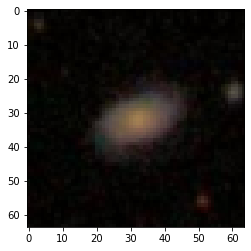

In [15]:
plt.imshow(X_train[2])

In [9]:
ORIG_SHAPE = (424,424)
CROP_SIZE = (256,256)
IMG_SHAPE = (64,64)
early_stop = EarlyStopping(monitor='loss', patience=4, restore_best_weights=True)

In [21]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Dense, BatchNormalization, GlobalMaxPooling2D
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

model = Sequential()
model.add(Conv2D(512, (3, 3), input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], 3)))
model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(GlobalMaxPooling2D())


model.add(Dropout(0.25))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(37))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adamax', metrics=[root_mean_squared_error])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 62, 62, 512)       14336     
                                                                 
 conv2d_7 (Conv2D)           (None, 60, 60, 256)       1179904   
                                                                 
 activation_7 (Activation)   (None, 60, 60, 256)       0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 256)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 256)       590080    
                                                                 
 conv2d_9 (Conv2D)           (None, 26, 26, 128)       295040    
                                                      

In [22]:
batch_size = 128
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test),callbacks=[early_stop])

Epoch 1/30
1540/1540 [==============================] - 309s 200ms/step - loss: 0.3001 - root_mean_squared_error: 0.1612 - val_loss: 0.2673 - val_root_mean_squared_error: 0.1307
Epoch 2/30
1540/1540 [==============================] - 320s 208ms/step - loss: 0.2634 - root_mean_squared_error: 0.1262 - val_loss: 0.2531 - val_root_mean_squared_error: 0.1153
Epoch 3/30
1540/1540 [==============================] - 330s 214ms/step - loss: 0.2562 - root_mean_squared_error: 0.1181 - val_loss: 0.2499 - val_root_mean_squared_error: 0.1109
Epoch 4/30
1540/1540 [==============================] - 324s 210ms/step - loss: 0.2528 - root_mean_squared_error: 0.1139 - val_loss: 0.2468 - val_root_mean_squared_error: 0.1067
Epoch 5/30
1540/1540 [==============================] - 341s 221ms/step - loss: 0.2504 - root_mean_squared_error: 0.1108 - val_loss: 0.2449 - val_root_mean_squared_error: 0.1041
Epoch 6/30
1540/1540 [==============================] - 329s 214ms/step - loss: 0.2484 - root_mean_squared_err

In [23]:
# serialize model to JSON
model_json = model.to_json()
with open("Output/Model/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("Output/Model/model.h5")
print("Saved model to disk")

Saved model to disk


In [8]:
from keras.models import model_from_json
# load json and create model
json_file = open('Output/Model/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
                        # load weights into new model
loaded_model.load_weights("Output/Model/model.h5")
print("Loaded model from disk")

Loaded model from disk


In [16]:
model.save_weights('30epoch_final_weights_1729.h5')
model.save('30epoch_final_model_1729.h5')
batch_size = 128

In [27]:
np.save('Output/Model/model_final_history.npy',history.history)

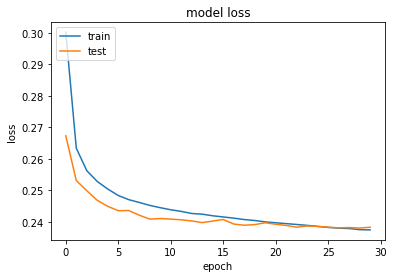

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Test Prediction Submission

In [68]:
import os
from tqdm import tqdm
def get_image(path, x1,y1, shape, crop_size):
    x = plt.imread(path)
    x = x[x1:x1+crop_size[0], y1:y1+crop_size[1]]
    x = resize(x, shape)
    return x
def test_image_generator(ids, shape=IMG_SHAPE):
    x1 = (ORIG_SHAPE[0]-CROP_SIZE[0])//2
    y1 = (ORIG_SHAPE[1]-CROP_SIZE[1])//2
    x_batch = []
    for i in ids:
        x = get_image('images_test_rev1/images_test_rev1/'+i, x1, y1, shape=IMG_SHAPE, crop_size=CROP_SIZE)
        x_batch.append(x)
    x_batch = np.array(x_batch)
    return x_batch

val_files = os.listdir('images_test_rev1/images_test_rev1/')
val_predictions = []
N_val = len(val_files)
for i in tqdm(np.arange(0, N_val, batch_size)):
    if i+batch_size > N_val:
        upper = N_val
    else:
        upper = i+batch_size
    X = test_image_generator(val_files[i:upper])
    y_pred = model.predict(X)
    val_predictions.append(y_pred)
val_predictions = np.array(val_predictions)
Y_pred = np.vstack(val_predictions)
ids = np.array([v.split('.')[0] for v in val_files]).reshape(len(val_files),1)
submission_df = pd.DataFrame(np.hstack((ids, Y_pred)), columns=df_train.columns)
submission_df = submission_df.sort_values(by=['GalaxyID'])
submission_df.to_csv('testing_solution1_final.csv', index=False)

100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [14:38<00:00,  1.41s/it]
<ipython-input-68-95e230e22d84>:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  val_predictions = np.array(val_predictions)


In [277]:
df = pd.read_csv("testing_solution1_final.csv")
cols = df.columns
# new = list(map(lambda s: s.replace('Class','Q'), cols))
new=[]
for i in range(len(cols)):
    new.append(cols[i].replace("Q","Class"))
df.columns = new


In [78]:
ellipticals = df[(df['Class1.1']>0.7) & (df['Class7.1']>0.4)]['GalaxyID'].tolist()

lenticulars = df[(df['Class1.1']>0.7) & (df['Class7.2']>0.4)]['GalaxyID'].tolist()

spirals = df[(df['Class1.2']>0.7) & (df['Class2.1']>0.4)]['GalaxyID'].tolist()

print('Total number of elliptical examples: ',  len(ellipticals))
print('Total number of lenticular examples: ',  len(lenticulars))
print('Total number of spiral examples: ',  len(spirals))

Total number of elliptical examples:  7129
Total number of lenticular examples:  6373
Total number of spiral examples:  4605


# Custom_input

In [4]:
ORIG_SHAPE = (424,424)
CROP_SIZE = (256,256)
IMG_SHAPE = (64,64)

def get_image(path, x1,y1, shape, crop_size):
    x = plt.imread(path)
#     x = x[x1:x1+crop_size[0], y1:y1+crop_size[1]]
    x = resize(x, shape)
    return x

In [12]:
import os
from tqdm import tqdm
batch_size = 128
def test_image_generator(ids, shape=IMG_SHAPE):
    x1 = (ORIG_SHAPE[0]-CROP_SIZE[0])//2
    y1 = (ORIG_SHAPE[1]-CROP_SIZE[1])//2
    x_batch = []
    for i in ids:
        x = get_image('Custom_input/'+i, x1, y1, shape=IMG_SHAPE, crop_size=CROP_SIZE)
        x_batch.append(x)
    x_batch = np.array(x_batch)
    return x_batch

val_files = os.listdir('Custom_input/')
val_predictions = []
N_val = len(val_files)
for i in tqdm(np.arange(0, N_val, batch_size)):
    if i+batch_size > N_val:
        upper = N_val
    else:
        upper = i+batch_size
    X = test_image_generator(val_files[i:upper])
    print(X.shape)
    y_pred = model.predict(X)
    val_predictions.append(y_pred)
val_predictions = np.array(val_predictions)
Y_pred = np.vstack(val_predictions)
ids = np.array([v.split('.')[0] for v in val_files]).reshape(len(val_files),1)
submission_df = pd.DataFrame(np.hstack((ids, Y_pred)), columns=df_train.columns)
submission_df = submission_df.sort_values(by=['GalaxyID'])
submission_df.to_csv('sample_submission_testing.csv', index=False)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

(2, 64, 64, 3)


NameError: name 'model' is not defined

# Summary Report Generator

In [132]:
import pandas as pd
df = pd.read_csv('sample_submission_testing.csv')
df = df.drop('GalaxyID',axis=1)

In [133]:
def return_result(path_obtained):
    print("The obtained classes are : ",path_obtained)
    print()
    if 'Class1.1' in path_obtained:
        print("It is a smooth Galaxy")
    if 'Class1.2' in path_obtained:
        print("It has features and disk")
    if 'Class1.3' in path_obtained:
        print("It is a star/artifact")

    if 'Class2.1' in path_obtained:
        print("It is a disk viewed edge on")
    if 'Class2.2' in path_obtained:
        print("It is not a disk viewed edge on")

    if 'Class3.1' in path_obtained:
        print("There is a bar feature at the center of galaxy")
    if 'Class3.2' in path_obtained:
        print("There is NO bar feature at the center of galaxy")

    if 'Class4.1' in path_obtained:
        print("There is a sign of spiral arm pattern")
    if 'Class4.2' in path_obtained:
        print("There is NO sign of spiral arm pattern")

    if 'Class5.1' in path_obtained:
        print("There is no Buldge in the center")
    if 'Class5.2' in path_obtained:
        print("There is a just noticible Buldge in the center")
    if 'Class5.3' in path_obtained:
        print("There is a obvious Buldge in the center")
    if 'Class5.4' in path_obtained:
        print("There is dominant Buldge in the center")

    if 'Class6.1' in path_obtained:
        print("There is something odd")
    if 'Class6.2' in path_obtained:
        print("There is nothing odd")


    if 'Class7.1' in path_obtained:
        print("It is completely round")
    if 'Class7.2' in path_obtained:
        print("It is inbetween round")
    if 'Class7.3' in path_obtained:
        print("It is cigar shaped")

    if 'Class8.1' in path_obtained:
        print("There is a ring")
    if 'Class8.2' in path_obtained:
        print("There is a lens or arc")
    if 'Class8.3' in path_obtained:
        print("It is distributed")
    if 'Class8.4' in path_obtained:
        print("It is irregular")
    if 'Class8.5' in path_obtained:
        print("Cant Find")
    if 'Class8.6' in path_obtained:
        print("It is a Merger Galaxy")
    if 'Class8.7' in path_obtained:
        print("There is a Dust Lane")

    if 'Class9.1' in path_obtained:
        print("It is rounded at the center")
    if 'Class9.2' in path_obtained:
        print("It is BOXY at the center")
    if 'Class9.3' in path_obtained:
        print("It has no buldge at the center")

    if 'Class10.1' in path_obtained:
        print("It has tight spiral arms")
    if 'Class10.2' in path_obtained:
        print("It has medium tight spiral arms")
    if 'Class10.3' in path_obtained:
        print("It has loose spiral arms")

    if 'Class11.1' in path_obtained:
        print("There is 1 spiral arm")
    if 'Class11.2' in path_obtained:
        print("There is 2 spiral arm")
    if 'Class11.3' in path_obtained:
        print("There is 3 spiral arm")
    if 'Class11.4' in path_obtained:
        print("There is 4 spiral arm")
    if 'Class11.5' in path_obtained:
        print("There is more than 4 spiral arm")
    if 'Class11.6' in path_obtained:
        print("Can't tell the number of spiral arm")

    print("The END")

In [134]:
df

,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,Class5.1,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,0.623882,0.324915,0.062576,0.125247,0.19701,0.094268,0.116127,0.035763,0.157835,0.012132,...,0.013054,0.012611,0.013435,0.014453,0.004041,0.014373,0.000471,0.000319,0.001802,0.014565


C:\Users\swade\anaconda3\lib\site-packages\pygraphviz\agraph.py:1402: RuntimeWarning: Warning: pos attribute for edge (root,Class1.1) doesn't have 3n+1 points

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


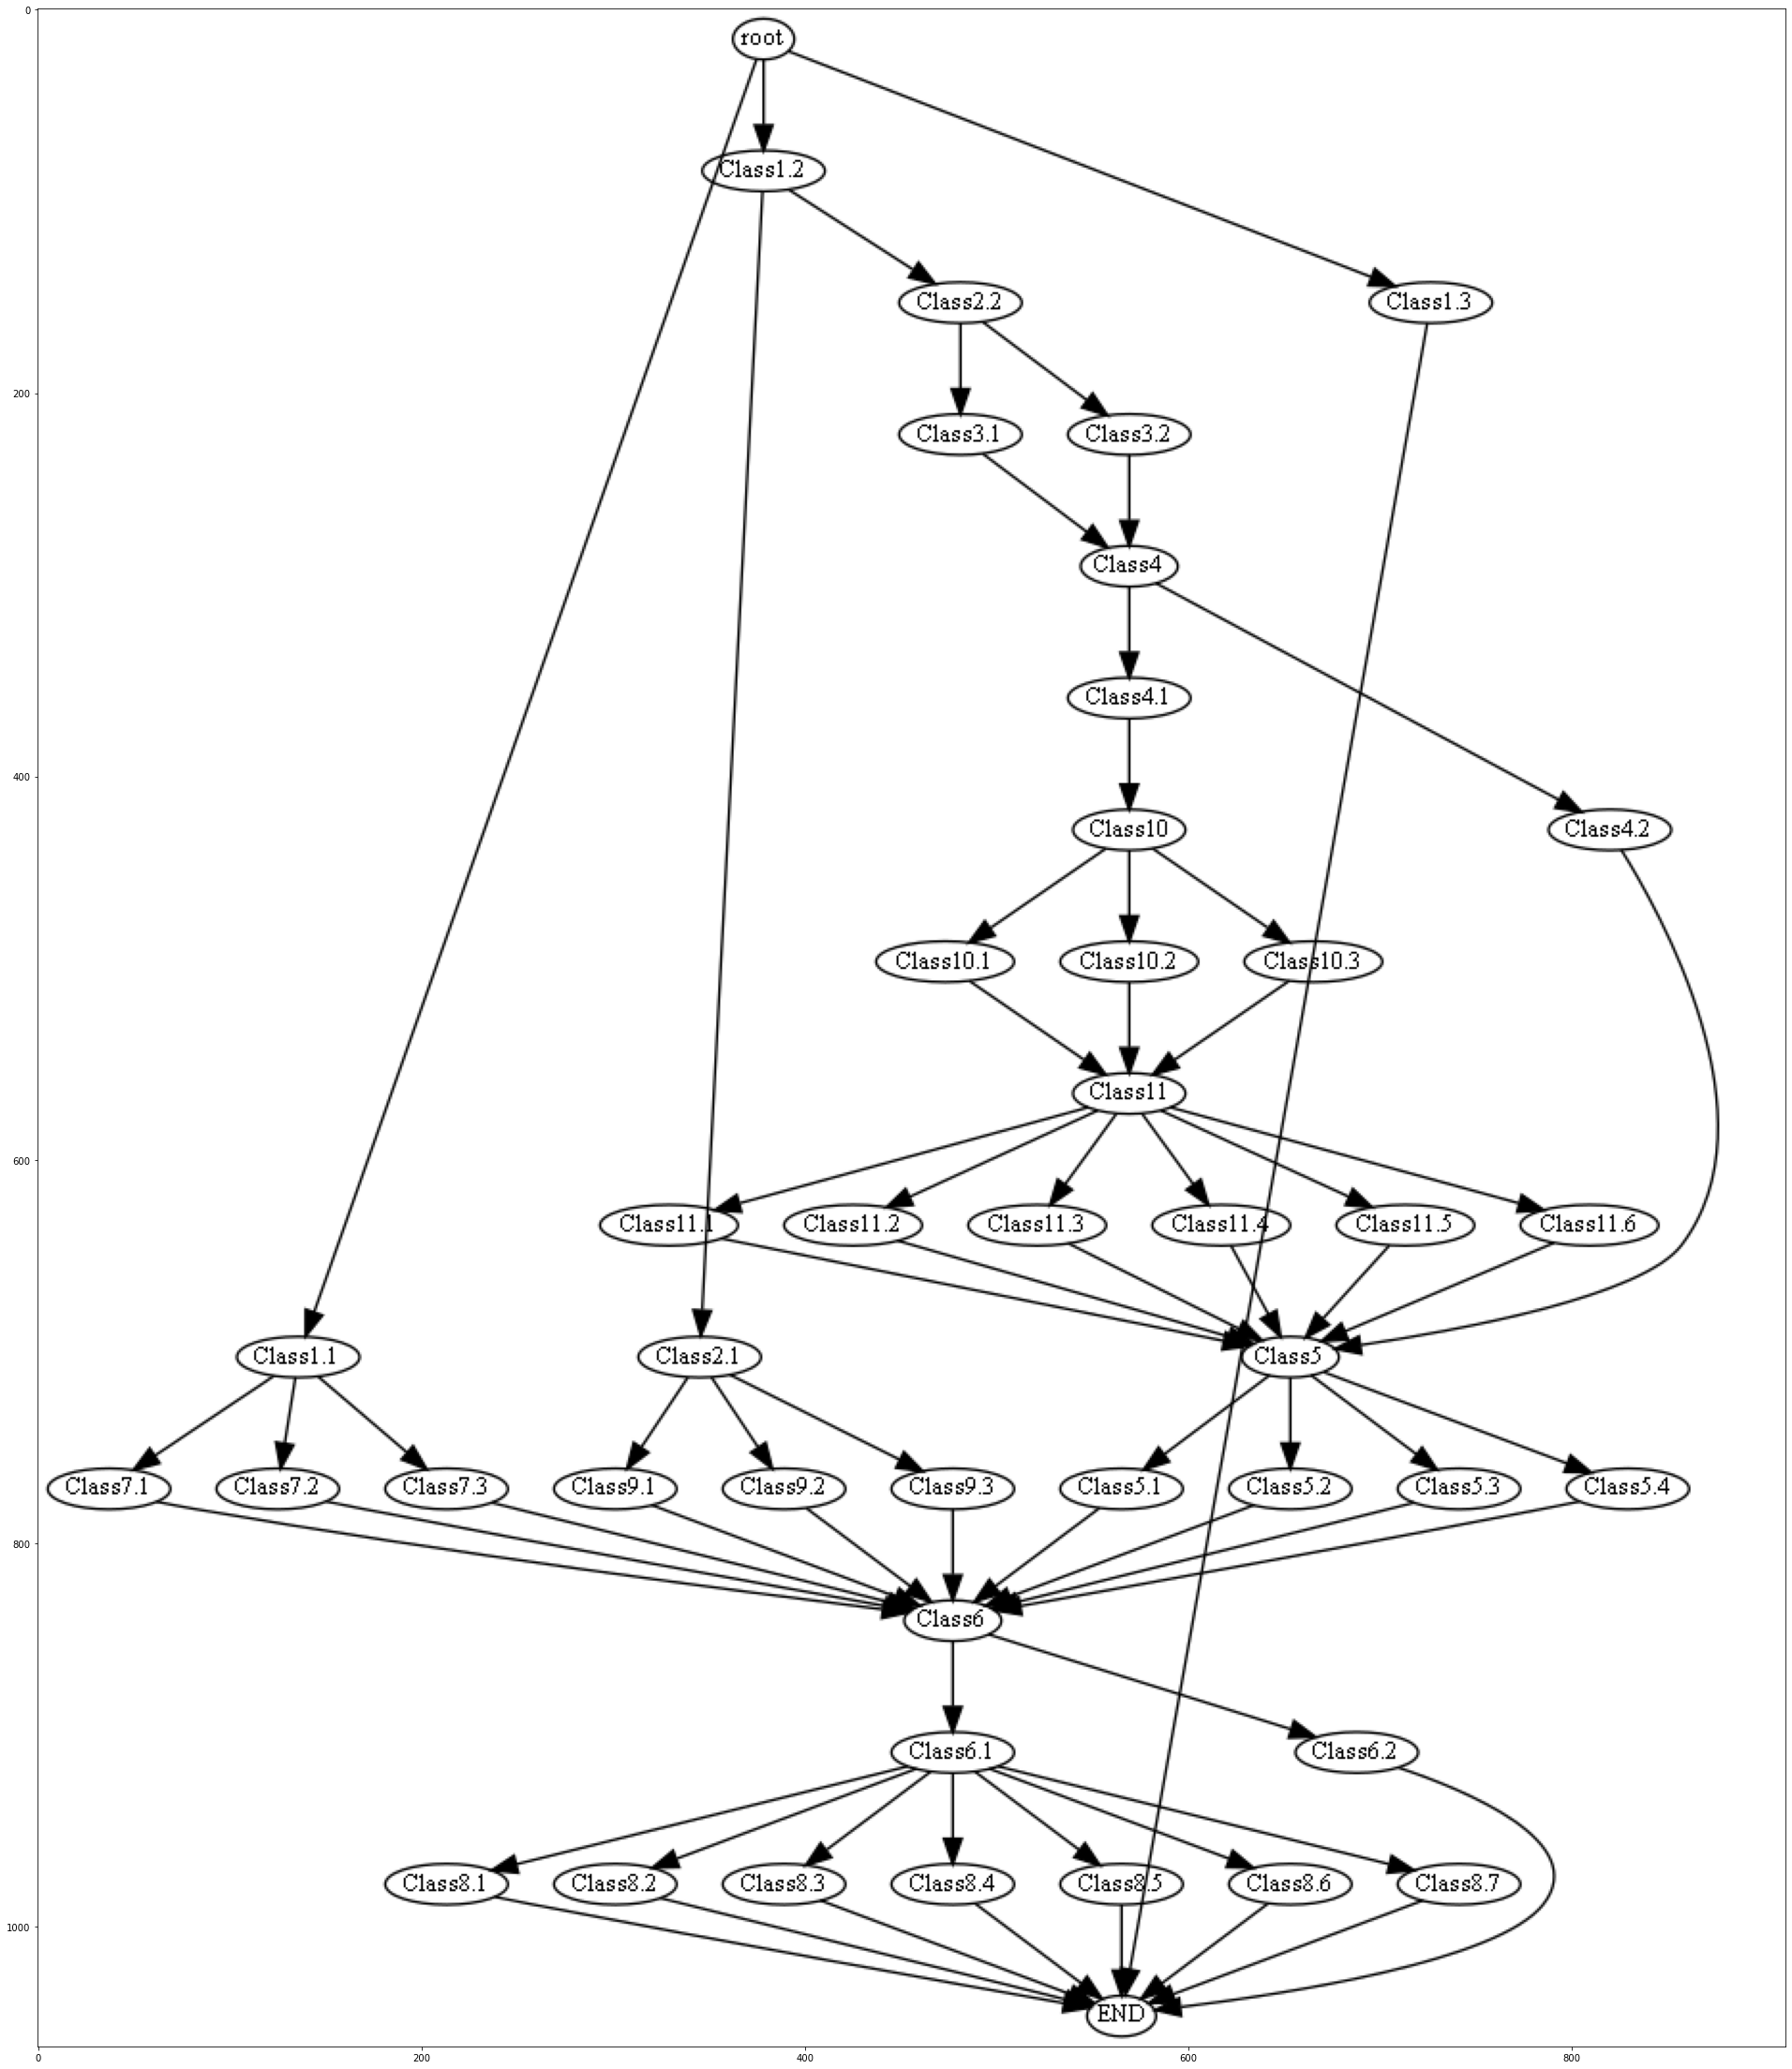

In [2]:
from matplotlib import pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
import networkx as nx
from PIL import Image
g1 = nx.DiGraph()
g1.add_edges_from([("root", "Class1.1"), ("root", "Class1.2"), ("root", "Class1.3"), ("Class1.1", "Class7.1"),("Class1.1", "Class7.2"),("Class1.1", "Class7.3"),("Class1.2", "Class2.1"),("Class1.2", "Class2.2"),
                  ("Class2.1", "Class9.1"),("Class2.1", "Class9.2"),("Class2.1", "Class9.3"),("Class2.2", "Class3.1"),("Class2.2", "Class3.2"),("Class7.1", "Class6"),("Class7.2", "Class6"),("Class7.3", "Class6"),
                  ("Class6","Class6.1"),("Class6","Class6.2"),("Class6.1","Class8.1"),("Class6.1","Class8.2"),("Class6.1","Class8.3"),("Class6.1","Class8.4"),("Class6.1","Class8.5"),("Class6.1","Class8.6"),("Class6.1","Class8.7"),
                   ("Class6.2","END"),("Class8.1","END"),("Class8.2","END"),("Class8.3","END"),("Class8.4","END"),("Class8.5","END"),("Class8.6","END"),("Class8.7","END"),("Class1.3","END"),
                  ("Class9.1", "Class6"),("Class9.2", "Class6"),("Class9.3", "Class6"),("Class3.1", "Class4"),("Class4","Class4.1"),("Class4","Class4.2"),("Class3.1", "Class4"),("Class3.2", "Class4"),("Class4.1", "Class10"),("Class4.2", "Class5"),
                  ("Class10","Class10.1"),("Class10","Class10.2"),("Class10","Class10.3"),("Class10.1","Class11"),("Class10.2","Class11"),("Class10.3","Class11"),
                  ("Class11","Class11.1"),("Class11","Class11.2"),("Class11","Class11.3"),("Class11","Class11.4"),("Class11","Class11.5"),("Class11","Class11.6"),
                  ("Class11.1","Class5"),("Class11.2","Class5"),("Class11.3","Class5"),("Class11.4","Class5"),("Class11.5","Class5"),("Class11.6","Class5"),
                  ("Class5","Class5.1"),("Class5","Class5.2"),("Class5","Class5.3"),("Class5","Class5.4"),("Class5.1","Class6"),("Class5.2","Class6"),("Class5.3","Class6"),("Class5.4","Class6")])

# nx.nx_agraph.write_dot(g1,'test.dot')
# pos=graphviz_layout(g1, prog='dot')
# nx.draw(g1, pos, with_labels=False, arrows=False)
# plt.show()

A = nx.nx_agraph.to_agraph(g1)
A.layout('dot', args='-Nfontsize=10 -Nwidth=".2" -Nheight=".2" -Nmargin=0 -Gfontsize=8')
A.draw('test.png')
img = Image.open('test.png')
plt.figure(figsize=(40,40))
plt.imshow(img)

In [269]:
edges = list(nx.edge_bfs(g1,"root"))
df1 = pd.DataFrame(edges)
df1.to_csv('tree.csv')

In [137]:
def search(className):
    cl = []
    for i,classes in enumerate(df1.iloc[:,0]):
        if(classes == className):
            cl.append(df1.iloc[i][1])
    return cl

In [138]:
search('Class7.2')

['Class6']

In [139]:
def find_max(row,classArr):
    max = -9999
    class_ans = ''
    for classes in classArr:
        if classes == 'Class6':
            return find_max(row,['Class6.1','Class6.2'])
        if classes == 'Class4':
            return find_max(row,['Class4.1','Class4.2'])
        if classes == 'Class10':
            return find_max(row,['Class10.1','Class10.2','Class10.3'])
        if classes == 'Class5':
            return find_max(row,['Class5.1','Class5.2','Class5.3','Class5.4'])
        if classes == 'Class11':
            return find_max(row,['Class11.1','Class11.2','Class11.3','Class11.4','Class11.5','Class11.6'])
        
        if df[classes][row] > max :
            max = df[classes][row]
            class_ans = classes
    return class_ans

In [140]:
search('Class6.2')[0]

'END'

In [141]:
df1.iloc[:,1]

0     Class1.1
1     Class1.2
2     Class1.3
3     Class7.1
4     Class7.2
        ...   
64      Class5
65      Class5
66      Class5
67      Class5
68      Class5
Name: 1, Length: 69, dtype: object

In [149]:
 def get_result(index):
    values_per_cat = np.array(df.iloc[index,0:3])
    maxarg = np.argmax(values_per_cat)
    begin = df.columns[maxarg]
    curr_class = begin
    path_obtained = []
    path_obtained.append(begin)
    while(True):
        print("Searchin child of",curr_class)
        arr = search(curr_class)
        if(arr[0] == 'END'):
            print("The end")
            break

        max_class = find_max(index,arr)
        print("Max of ",curr_class,"is",max_class)
        curr_class = max_class
        path_obtained.append(curr_class)
        
    return path_obtained

In [150]:
path_obtained = get_result(0)

Searchin child of Class1.1
Max of  Class1.1 is Class7.2
Searchin child of Class7.2
Max of  Class7.2 is Class6.2
Searchin child of Class6.2
The end


In [151]:
path_obtained

['Class1.1', 'Class7.2', 'Class6.2']

In [144]:
return_result(path_obtained)

The obtained classes are :  ['Class1.1', 'Class7.2', 'Class6.2']

It is a smooth Galaxy
There is nothing odd
It is inbetween round
The END


## Test and Train Accuracy

In [157]:
len(X_train)

49262

In [220]:
# train Accuracy
def get_accuracy(N_val,X,y):
    val_predictions = []
    for i in tqdm(np.arange(0, N_val, batch_size)):
        if i+batch_size > N_val:
            upper = N_val
        else:
            upper = i+batch_size
        X_t = X[i:upper]
        y_pred = model.predict(X_t)
        val_predictions.append(y_pred)
    
    return val_predictions

In [240]:
train_pred = np.vstack(get_accuracy(len(X_train),X_train,y_train))
test_pred = np.vstack(get_accuracy(len(X_test),X_test,y_test))

100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [00:19<00:00,  4.92it/s]


In [244]:
submission_df = pd.DataFrame(train_pred, columns=['Class1.1', 'Class1.2', 'Class1.3', 'Class2.1', 'Class2.2',
       'Class3.1', 'Class3.2', 'Class4.1', 'Class4.2', 'Class5.1', 'Class5.2',
       'Class5.3', 'Class5.4', 'Class6.1', 'Class6.2', 'Class7.1', 'Class7.2',
       'Class7.3', 'Class8.1', 'Class8.2', 'Class8.3', 'Class8.4', 'Class8.5',
       'Class8.6', 'Class8.7', 'Class9.1', 'Class9.2', 'Class9.3', 'Class10.1',
       'Class10.2', 'Class10.3', 'Class11.1', 'Class11.2', 'Class11.3',
       'Class11.4', 'Class11.5', 'Class11.6'])
submission_df.to_csv('Output/Intermediate/TrainPred.csv', index=False)

In [245]:
submission_df = pd.DataFrame(y_train, columns=['Class1.1', 'Class1.2', 'Class1.3', 'Class2.1', 'Class2.2',
       'Class3.1', 'Class3.2', 'Class4.1', 'Class4.2', 'Class5.1', 'Class5.2',
       'Class5.3', 'Class5.4', 'Class6.1', 'Class6.2', 'Class7.1', 'Class7.2',
       'Class7.3', 'Class8.1', 'Class8.2', 'Class8.3', 'Class8.4', 'Class8.5',
       'Class8.6', 'Class8.7', 'Class9.1', 'Class9.2', 'Class9.3', 'Class10.1',
       'Class10.2', 'Class10.3', 'Class11.1', 'Class11.2', 'Class11.3',
       'Class11.4', 'Class11.5', 'Class11.6'])
submission_df.to_csv('Output/Intermediate/TrainActual.csv', index=False)

In [287]:
 
def get_results(index,df):
    values_per_cat = np.array(df.iloc[index,0:3])
    maxarg = np.argmax(values_per_cat)
    begin = df.columns[maxarg]
    curr_class = begin
    path_obtained = []
    path_obtained.append(begin)
    while(True):
#         print("Searchin child of",curr_class)
        arr = search(curr_class)
        if(arr[0] == 'END'):
#             print("The end")
            break

        max_class = find_max(index,arr)
#         print("Max of ",curr_class,"is",max_class)
        curr_class = max_class
        path_obtained.append(curr_class)
        
    return path_obtained

In [288]:
#Train Actual Values
df = pd.read_csv('Output/Intermediate/TrainActual.csv')
df11 = pd.read_csv('Output/Intermediate/TrainPred.csv')
correct = 0
for i in range(len(df)):
    path_obtained_pred = get_results(i,df11)
    path_obtained_act = get_results(i,df)
    
    if path_obtained_pred == path_obtained_act:
        correct+=1
    
correct/len(df)

0.8859973204498396

In [296]:
print("Train Accuracy is : ",correct/len(df) * 100 , "%")

Train Accuracy is :  88.59973204498395 %


In [297]:
submission_df = pd.DataFrame(test_pred, columns=['Class1.1', 'Class1.2', 'Class1.3', 'Class2.1', 'Class2.2',
       'Class3.1', 'Class3.2', 'Class4.1', 'Class4.2', 'Class5.1', 'Class5.2',
       'Class5.3', 'Class5.4', 'Class6.1', 'Class6.2', 'Class7.1', 'Class7.2',
       'Class7.3', 'Class8.1', 'Class8.2', 'Class8.3', 'Class8.4', 'Class8.5',
       'Class8.6', 'Class8.7', 'Class9.1', 'Class9.2', 'Class9.3', 'Class10.1',
       'Class10.2', 'Class10.3', 'Class11.1', 'Class11.2', 'Class11.3',
       'Class11.4', 'Class11.5', 'Class11.6'])
submission_df.to_csv('Output/Intermediate/TestPred.csv', index=False)

In [298]:
submission_df = pd.DataFrame(y_test, columns=['Class1.1', 'Class1.2', 'Class1.3', 'Class2.1', 'Class2.2',
       'Class3.1', 'Class3.2', 'Class4.1', 'Class4.2', 'Class5.1', 'Class5.2',
       'Class5.3', 'Class5.4', 'Class6.1', 'Class6.2', 'Class7.1', 'Class7.2',
       'Class7.3', 'Class8.1', 'Class8.2', 'Class8.3', 'Class8.4', 'Class8.5',
       'Class8.6', 'Class8.7', 'Class9.1', 'Class9.2', 'Class9.3', 'Class10.1',
       'Class10.2', 'Class10.3', 'Class11.1', 'Class11.2', 'Class11.3',
       'Class11.4', 'Class11.5', 'Class11.6'])
submission_df.to_csv('Output/Intermediate/TestAct.csv', index=False)

In [299]:
df = pd.read_csv('Output/Intermediate/TestAct.csv')
df11 = pd.read_csv('Output/Intermediate/TestPred.csv')
correct = 0
for i in range(len(df)):
    path_obtained_pred = get_results(i,df11)
    path_obtained_act = get_results(i,df)
    
    if path_obtained_pred == path_obtained_act:
        correct+=1
    
correct/len(df)

0.8609126339720689

In [300]:
print("Test Accuracy is : ",correct/len(df) * 100 , "%")

Test Accuracy is :  86.09126339720689 %
